<a href="https://colab.research.google.com/github/savindu29/NeuralNet/blob/main/EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading the dataset (BCI Competition IV 2a)

In [2]:
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip


--2025-02-07 11:31:55--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
Resolving www.bbci.de (www.bbci.de)... 130.149.80.149
Connecting to www.bbci.de (www.bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439968864 (420M) [application/zip]
Saving to: ‘BCICIV_2a_gdf.zip’

BCICIV_2a_gdf.zip   100%[===================>] 419.59M  10.9MB/s    in 23s     

2025-02-07 11:32:19 (17.9 MB/s) - ‘BCICIV_2a_gdf.zip’ saved [439968864/439968864]



In [3]:
!mkdir -p /content/cleaned_data/

In [4]:
%%capture
!unzip /content/BCICIV_2a_gdf.zip -d raw_data

##Install Libraries

In [ ]:
%%capture
!pip install mne

In [ ]:
%%capture
!pip install torch-summary

In [ ]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

#Organize the dataset

In [ ]:
!mkdir -p /content/cleaned_data/first_session
!mkdir -p /content/cleaned_data/second_session

##First Session Data Preprocess

In [ ]:
raw_data_folder = '/content/raw_data/'
cleaned_data_folder = '/content/cleaned_data/first_session/'
files = os.listdir(raw_data_folder)

# Selecting files with suffix 'T.gdf'
filtered_files = [file for file in files if file.endswith('T.gdf')]

raw_list = []

# Iterating through filtered files
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Reading raw data
    raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
    # Droping EOG channels
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    # High Pass Filtering 4-40 Hz
    raw.filter(l_freq=4, h_freq=40, method='iir')

    # Notch filter for Removal of Line Voltage
    raw.notch_filter(freqs=50)

    # Saving the modified raw data to a file with .fif suffix
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)
    # Appending data to the list
    raw_list.append(raw)

final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'First_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)

In [ ]:
events = mne.events_from_annotations(final_raw)
events[1]

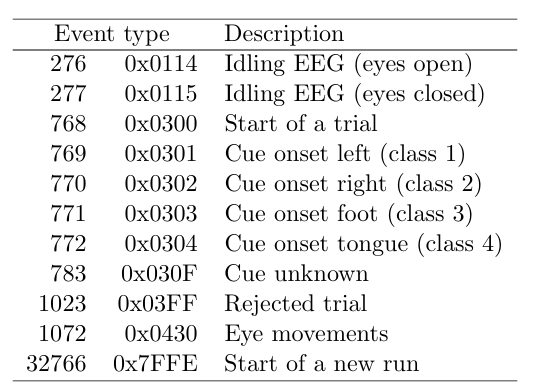

In [ ]:
epochs = mne.Epochs(final_raw, events[0], event_id=[7, 8, 9, 10], tmin=0, tmax=4, reject=None, baseline=None, preload=True)
first_session_data = epochs.get_data(copy=True)
first_session_labels = epochs.events[:,-1]

In [ ]:
print("First_session_dataset shape:",first_session_data.shape)

##Second Session Process

In [ ]:
##Second Session Process

In [ ]:
# shareable link
shareable_link = 'https://drive.google.com/file/d/1LizqO0zGP1Cs9tSgYfQaao6Yngr16-zK/view?usp=drive_link'

# Extract file ID from the shareable link
file_id = shareable_link.split('/d/')[1].split('/view')[0]

# Create the direct download link
download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

# Specify the output file path
output_file = 'true_labels.zip'

# Download the file
gdown.download(download_url, output_file, quiet=False)

In [ ]:
%%capture
!unzip /content/true_labels.zip -d second_session_labels

In [ ]:
raw_data_folder = '/content/raw_data/'
cleaned_data_folder = '/content/cleaned_data/second_session/'
mat_folder = '/content/second_session_labels/'

# Selecting files with suffix 'E.mat'
mat_files = os.listdir(mat_folder)
filtered_math_labels = [file for file in mat_files if file.endswith('E.mat')]

# Selecting files with suffix 'E.gdf'
files = os.listdir(raw_data_folder)
filtered_files = [file for file in files if file.endswith('E.gdf')]

raw_list = []
second_session_labels = np.array([])
# Iterating through filtered files
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Reading raw data
    raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
    # Droping EOG channels
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    # High Pass Filtering 4-40 Hz
    raw.filter(l_freq=4, h_freq=40, method='iir')

    # Saving the modified raw data to a file with .fif suffix
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)
    # Appending data to t he list
    raw_list.append(raw)

    # Mat files for the labels
    mat_file_name = file.replace('.gdf', '.mat')
    mat_file_path = os.path.join(mat_folder, mat_file_name)
    print(f"data:{file}, label:{mat_file_name}")

    if os.path.exists(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        class_labels = mat_data.get('classlabel', [])

        # Check if 'classlabel' key exists and is not empty
        if class_labels.size > 0:
             # Convert to a NumPy array and flatten
            class_labels_array = np.array(class_labels, dtype=int).flatten()
            # Concatenate with the existing test_labels array
            second_session_labels = np.concatenate((second_session_labels, class_labels_array))
        else:
            print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
    else:
        print(f"Warning: {mat_file_name} not found.")

final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'Second_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)

In [ ]:
events = mne.events_from_annotations(final_raw)
events[1]

In [ ]:
epochs = mne.Epochs(final_raw, events[0], event_id=7, tmin=0, tmax=4, reject=None, baseline=None, preload=None)
second_session_data = epochs.get_data(copy=True)

In [ ]:
print("Second Session Dataset shape:",second_session_data.shape)

#Structuring the Date

In [ ]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Normalizing Labels to [0, 1, 2, 3]
y_train = first_session_labels - np.min(first_session_labels)
y_test = second_session_labels - np.min(second_session_labels)

# Normalizing Input features: z-score(mean=0, std=1)
X_first_session = (first_session_data - np.mean(first_session_data)) / np.std(first_session_data)
X_second_session = (second_session_data - np.mean(second_session_data)) / np.std(second_session_data)

X = np.concatenate((X_first_session, X_second_session))
y = np.concatenate((y_train, y_test))

# Spliting  Data: 90% for Train and 10% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())

#Model training class

In [ ]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        highest_train_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model

#Model Evaluation class

In [ ]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()

#EEGNet Model

In [ ]:

class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

##Summary

In [ ]:
input_size = (1, 22, 1001)
eegnet_model = EEGNetModel().to(device)
summary(eegnet_model, input_size)

#Model Training

In [ ]:
eegnet_model = EEGNetModel().to(device)

# Training Hyperparameters
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel()
trained_eegnet_model = trainer.train_model(eegnet_model, train_dataset, learning_rate=LEARNING_RATE,
                                   batch_size=BATCH_SIZE, epochs=EPOCHS)
torch.save(trained_eegnet_model.state_dict(), 'eegnet_model.pth')


#Evaluating Model

In [ ]:
classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)